In [6]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCPCN, FCPCNV2
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset
from tqdm import tqdm
from pclib.optim.train import val_pass

In [7]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
torch.manual_seed(seed)

# Scale img transform
class Scale(object):
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        return img * self.scale_factor + 0.5 * (1 - self.scale_factor)

# Inverse Logistic Sigmoid Transform
class InvLogit(object):
    def __call__(self, x):
        return torch.log(x / (1 - x))

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # Scale(0.9),
    # InvLogit(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
subset = 50
dataset = torch.utils.data.Subset(dataset, range(subset))

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

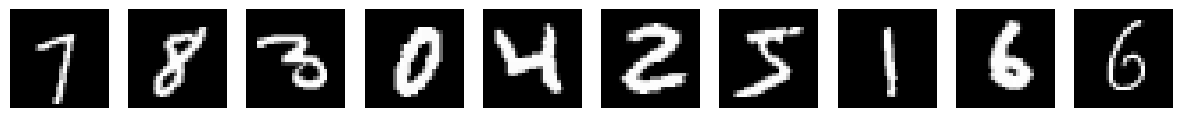

Max value:  tensor(2.8215, device='cuda:0')
Min value:  tensor(-0.4242, device='cuda:0')


In [9]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [10]:
all_stats = {}

In [27]:
def train(
        model,
        BATCH_SIZE,
        NUM_EPOCHS,
        train_dataset,
        val_dataset,
        optimiser,
        scheduler,
        stats,
        pos_states,
        neg_states,
        eval_every=500,
        norm_grads=False,
        neg_cnst=0.0,
        cd = 0,
):
    # Init data
    valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

    gamma = torch.ones(BATCH_SIZE, device=device) * 0.2

    for batch_idx in range(len(pos_states)):
        for _ in range(50):
            model.step(pos_states[batch_idx], gamma, pin_obs=True)
            if neg_cnst > 0:
                model.step(neg_states[batch_idx], gamma, pin_obs=False)

    for i in range(NUM_EPOCHS):

        # Epoch stats
        epochPosVfes = []
        epochNegVfes = []
        epochCdVfes = []

        # TQDM loop
        loop = tqdm(range(len(pos_states)), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            if neg_cnst > 0:
                loop.set_postfix({'steps': i, 'posVFE': stats['posVfe'][-1], 'valVFE': stats['valVfe'][-1], 'negVFE': stats['negVfe'][-1]})#, 'valVFE': stats['valVfe'][-1], 'valAcc': stats['valAcc'][-1]})
            if cd > 0:
                loop.set_postfix({'steps': i, 'posVFE': stats['posVfe'][-1], 'valVFE': stats['valVfe'][-1], 'cdVFE': stats['cdVfe'][-1]})
            else:
                loop.set_postfix({'steps': i, 'posVFE': stats['posVfe'][-1], 'valVFE': stats['valVfe'][-1]})

        # Iterate over all batches
        for batch_idx in loop:
            model.train()
            # Update particles and calculate new VFE
            model.step(pos_states[batch_idx], gamma, pin_obs=True)
            model.step(neg_states[batch_idx], gamma, pin_obs=True)

            cross_state = [{k: v.detach().clone() for k, v in state_l.items()} for state_l in pos_states[batch_idx]]
            for i, layer in enumerate(model.layers):
                if i < len(model.layers) - 1:
                    pred = model.layers[i+1].predict(neg_states[batch_idx][i+1])
                else:
                    pred = model.top.predict(neg_states[batch_idx][i])
                cross_state[i]['e'] = cross_state[i]['x'] - pred
                    


            pos_vfe = model.vfe(pos_states[batch_idx], normalise=norm_grads)

            # Update model parameters
            optimiser.zero_grad()
            loss = pos_vfe

            model.eval()
            # Same For Negative particles
            if neg_cnst > 0:
                model.step(neg_states[batch_idx], gamma, pin_obs=False)
                neg_vfe = model.vfe(neg_states[batch_idx], normalise=norm_grads)
                loss -= neg_cnst*neg_vfe
            if cd > 0:
                cd_state = [{k: v.clone() for k, v in state_l.items()} for state_l in pos_states[batch_idx]]
                for _ in range(cd):
                    model.step(cd_state, gamma, pin_obs=False)
                
                # out, _ = model.reconstruct(cd_state[0]['x'], steps=cd)
                # cd_state[0]['x'] = out
                cd_vfe = model.vfe(cd_state, normalise=norm_grads)
                loss -= 0.75*cd_vfe

            loss.backward()
            optimiser.step()
            # for layer in model.layers:
            #     if layer.in_features is not None:
            #         layer.weight.data = F.normalize(layer.weight.data, dim=1)
            # model.top.weight.data = F.normalize(model.top.weight.data, dim=1)

            # if norm_grads, recalculate VFE WITHOUT normalisation for plotting (otherwise it will be constant)
            if norm_grads:
                pos_vfe = model.vfe(pos_states[batch_idx], normalise=False)
                if neg_cnst:
                    neg_vfe = model.vfe(neg_states[batch_idx], normalise=False)
                if cd > 0:
                    cd_vfe = model.vfe(cd_state, normalise=False)

            epochPosVfes.append(pos_vfe.item())
            if neg_cnst:
                epochNegVfes.append(neg_vfe.item())
            if cd:
                epochCdVfes.append(cd_vfe.item())

        # Track epoch stats
        stats['posVfe'].append(torch.tensor(epochPosVfes).mean().item())
        if neg_cnst:
            stats['negVfe'].append(torch.tensor(epochNegVfes).mean().item())
        if cd:
            stats['cdVfe'].append(torch.tensor(epochCdVfes).mean().item())

        # Update learning rate
        if scheduler is not None:
            scheduler.step(stats['posVfe'][-1])

        # Validation pass
        if i % eval_every == 0:
            val_results = val_pass(model, None, valLoader, True, False, None)
            stats['valVfe'].append(val_results['vfe'].item())
            stats['valAcc'].append(val_results['acc'].item())
            # if neg_particles:
            #     neg_states = [model.init_state(x.flatten(1)) for (x, _) in trainLoader]
        
        stats['epoch'] += 1
    
def train_classifier(
        model,
        classifier,
        NUM_EPOCHS,
        train_dataset,
        val_dataset,
        stats,
):
    # Init data
    trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_dataset, batch_size=200, shuffle=False)

    for i in range(NUM_EPOCHS):

        # Epoch stats
        epochLosses = []

        optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.001)  

        # TQDM loop
        loop = tqdm(trainLoader, total=len(trainLoader), leave=False)
        loop.set_description('Epoch [{}/{}]'.format(i, NUM_EPOCHS))
        if stats['epoch'] > 0:
            loop.set_postfix({'steps': i, 'valAcc': stats['valAcc'][-1], 'valLoss': stats['valLoss'][-1]})

        # Iterate over all batches
        for (images, labels) in loop:
            images = images.flatten(1)

            out, state = model(images)
            out = classifier(out)

            model.zero_grad()
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimiser.step()
            epochLosses.append(loss.item())

        # Track epoch stats
        stats['trainLoss'].append(torch.tensor(epochLosses).mean())

        # Update learning rate
        # if scheduler is not None:
        #     scheduler.step(stats['ValAcc'][-1])

        # Validation pass
        val_results = val_pass(model, None, valLoader, True, True, None)
        stats['valAcc'].append(val_results['acc'].item())
        stats['valLoss'].append(val_results['loss'].item())
        
        stats['epoch'] += 1

In [28]:
torch.manual_seed(seed)

model_name = 'original'
model = FCPCNV2(
    # sizes=[INPUT_SHAPE, 600, 600, 20],
    sizes = [INPUT_SHAPE,],
    bias=True, 
    symmetric=True, 
    actv_fn=F.relu,
    steps=20,
    gamma=0.2,
    x_decay=0.0,
    dropout=0.2,
    # has_memory_vec=True,
).to(device)
stats = {
    'epoch': 0,
    'posVfe': [],
    'negVfe': [],
    'cdVfe': [],
    'valVfe': [],
    'valAcc': [],
}
# Init particles
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=40, shuffle=True)
pos_xs = [x.flatten(1) for (x, _) in trainLoader]
neg_xs = [x + torch.randn_like(x)*0.3 for x in pos_xs]
pos_states = [model.init_state(x) for x in pos_xs]
neg_states = [model.init_state(x) for x in neg_xs]

In [29]:
BATCH_SIZE = 40
NUM_EPOCHS = 10000
optimiser = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=500, factor=0.5, verbose=True, threshold=1e-4, min_lr=1e-9)
train(
    model,
    BATCH_SIZE,
    NUM_EPOCHS,
    train_dataset,
    val_dataset,
    optimiser,
    # scheduler,
    None,
    stats,
    pos_states,
    neg_states,
    25,
    norm_grads=False,
    neg_cnst =0.0,
    cd=0,
)

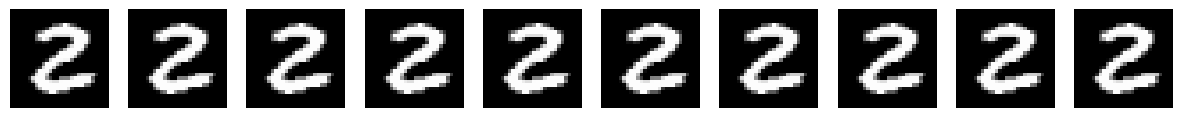

In [30]:
fig, ax = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    img = pos_states[0][0]['x'][0].cpu().detach().numpy().reshape(28, 28)
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
    for _ in range(10):
        model.step(pos_states[0], torch.ones(BATCH_SIZE, device=device) * 0.2, pin_obs=True)

plt.show()

In [31]:
all_stats['classic'] = stats

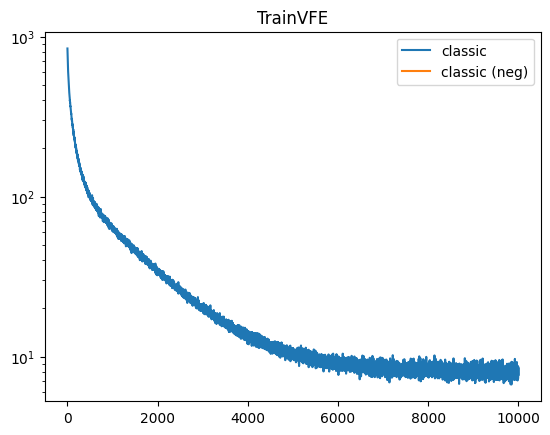

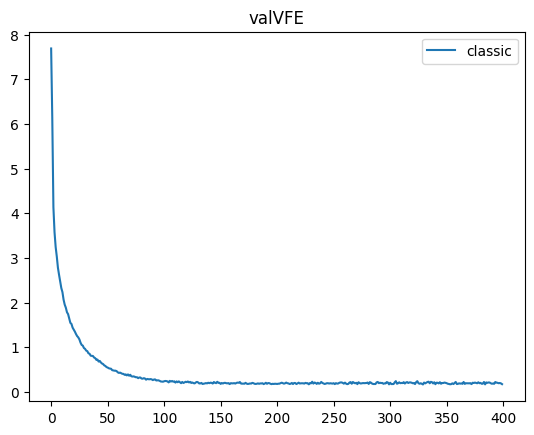

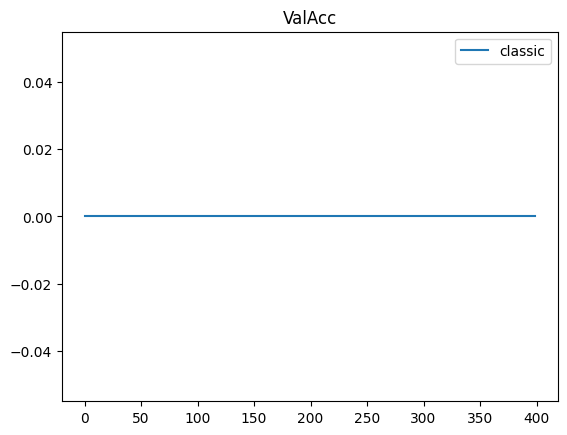

In [32]:
for k, v in all_stats.items():
    plt.plot(v['posVfe'], label=k)
    plt.plot(v['negVfe'], label=k+' (neg)')
plt.legend()
plt.yscale('log')
plt.title('TrainVFE')
plt.show()

for k, v in all_stats.items():
    plt.plot(v['valVfe'], label=k)
plt.legend()
plt.title('valVFE')
plt.show()

for k, v in all_stats.items():
    plt.plot(v['valAcc'], label=k)
plt.legend()
plt.title('ValAcc')
# plt.yscale('log')
plt.show()

In [21]:
model.eval()
x = train_dataset.transformed_images[10].flatten(1)
out, state = model(x, pin_obs=True, steps=50)
model.vfe(state)

tensor(1.0914, device='cuda:0', grad_fn=<MeanBackward0>)

In [18]:
classifier = torch.nn.Sequential(
    torch.nn.Linear(20, 10),
).to(device)
class_stats = {
    'epoch': 0,
    'trainLoss': [],
    'valAcc': [],
    'valLoss': [],
}

In [19]:
train_classifier(
    model,
    classifier,
    NUM_EPOCHS,
    train_dataset,
    val_dataset,
    class_stats,
    # eval_every=10,
)

KeyboardInterrupt: 

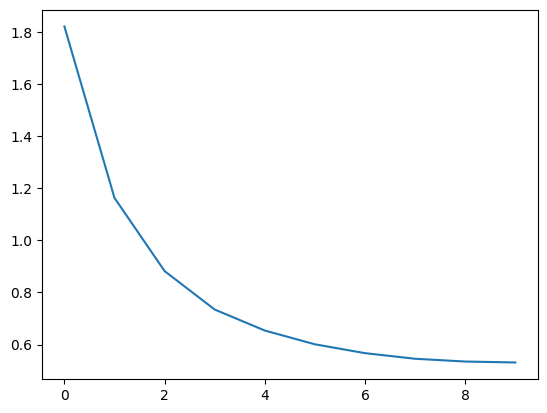

In [20]:
plt.plot(class_stats['trainLoss'], label='trainLoss')

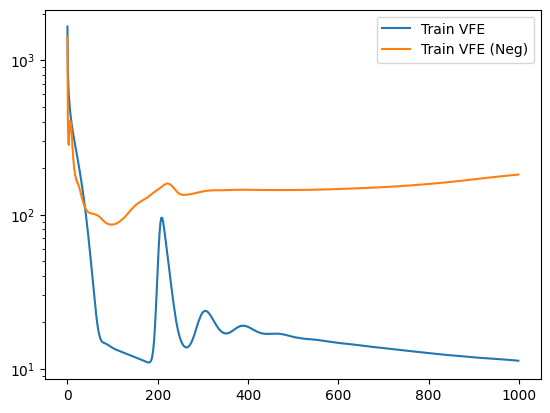

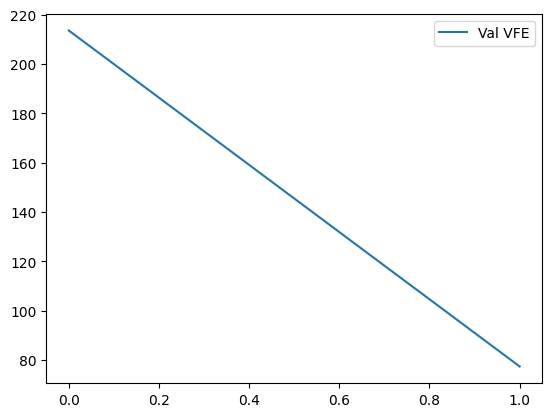

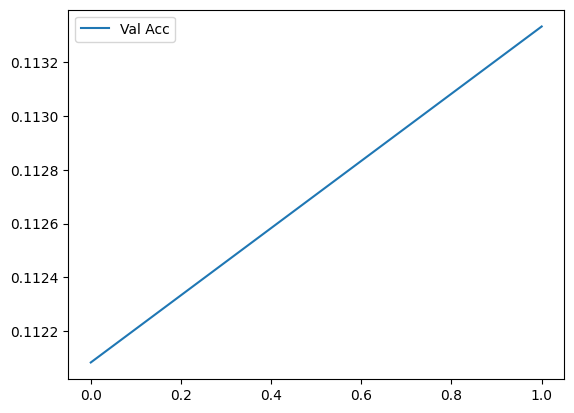

In [11]:
plt.plot(stats['trainVfe'], label='Train VFE')
plt.plot(stats['negVfe'], label='Train VFE (Neg)')
# plt.plot(sameneg_stats['trainVfe'], label='Train VFE (Neg)')
# plt.plot(noneg_nonorm_stats['trainVfe'], label='Train VFE (No Norm)')
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(stats['valVfe'], label='Val VFE')
# plt.plot(stats['valVfe'], label='Val VFE (Neg)')
# plt.plot(noneg_nonorm_stats['valVfe'], label='Val VFE (No Norm)')
plt.legend()
plt.show()

plt.plot(stats['valAcc'], label='Val Acc')
# plt.plot(sameneg_stats['valAcc'], label='Val Acc (Neg)')
# plt.plot(noneg_nonorm_stats['valAcc'], label='Val Acc (No Norm)')
plt.legend()
plt.show()

TypeError: list indices must be integers or slices, not str

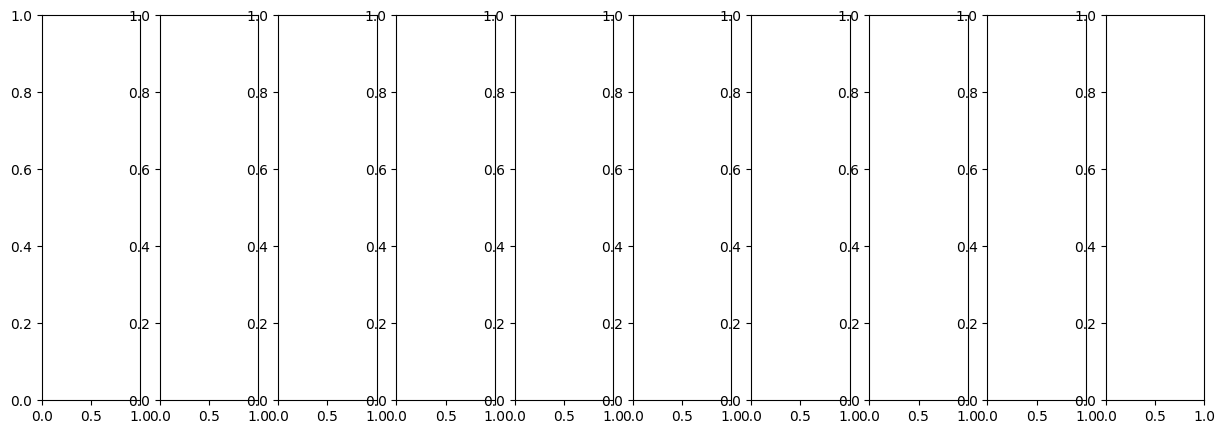

In [97]:
x = train_dataset.images[1].flatten(1).clone()
# x += torch.randn_like(x) * 0.8
# x[torch.rand_like(x) > 0.6] = 0.0
model.eval()

# vfes = []
# x = train_dataset.transformed_images[1].flatten(1)
# state = model.init_state(x)
# # gamma = torch.ones(BATCH_SIZE, device=device) * 0.2
# gamma = torch.ones(1, device=device) * 0.2
# for i in range(100):
#     model.step(state, gamma, pin_obs=True)
#     if i > 50: 
#         vfes.append(model.vfe(state, normalise=False).item())
#         if len(vfes) > 2 and vfes[-1] > vfes[-2]:
#             gamma *= 0.8

# plt.plot(vfes)
# plt.yscale('log')

state = [pos_state_l.copy() for pos_state_l in pos_states[0]]
# state[0]['x'] += torch.randn_like(state[0]['x']) * 100

fig, ax = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    out, state = model.reconstruct(state[0]['x'], steps=50)
    ax[i].imshow(out[2].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    ax[i].axis('off')

In [96]:
for pos_state_l in pos_states[0]:
    print(type(pos_state_l))

dic_lis = [{'x': torch.randn(4)}, {'x': torch.randn(4)}]

<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


In [112]:
state = [pos_state_l.copy() for pos_state_l in pos_states[0]]
state[0]['x'] += torch.randn_like(state[0]['x']) * 100
state[0]['x'].std()

tensor(359.1956, device='cuda:0')

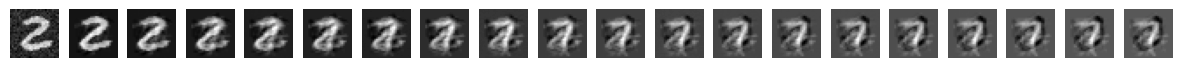

In [39]:
copy_dic = [{k: v.clone() for k, v in state_l.items()} for state_l in pos_states[0]]
copy_dic[0]['x'] += torch.randn_like(copy_dic[0]['x']) * 0.3

fig, axes = plt.subplots(1, 20, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = copy_dic[0]['x'][0].cpu().detach().numpy().reshape(28, 28)
    for _ in range(50):
        model.step(copy_dic, torch.ones(BATCH_SIZE, device=device) * 0.2, pin_obs=False)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

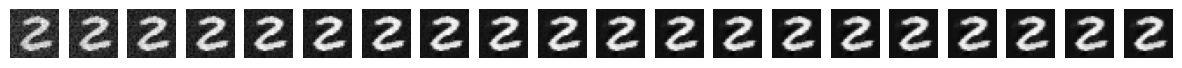

In [38]:
copy_dic = [{k: v.clone() for k, v in state_l.items()} for state_l in pos_states[0]]
copy_dic[0]['x'] += torch.randn_like(copy_dic[0]['x']) * 0.3

state = model.init_state(copy_dic[0]['x'])

fig, axes = plt.subplots(1, 20, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = state[0]['x'][0].cpu().detach().numpy().reshape(28, 28)
    # for _ in range(50):
    model.step(state, torch.ones(BATCH_SIZE, device=device) * 0.2, pin_obs=False)
    # out, state = model.reconstruct(state[0]['x'], steps=50)
    # state[0]['x'] = out
    ax.imshow(img, cmap='gray')
    ax.axis('off')

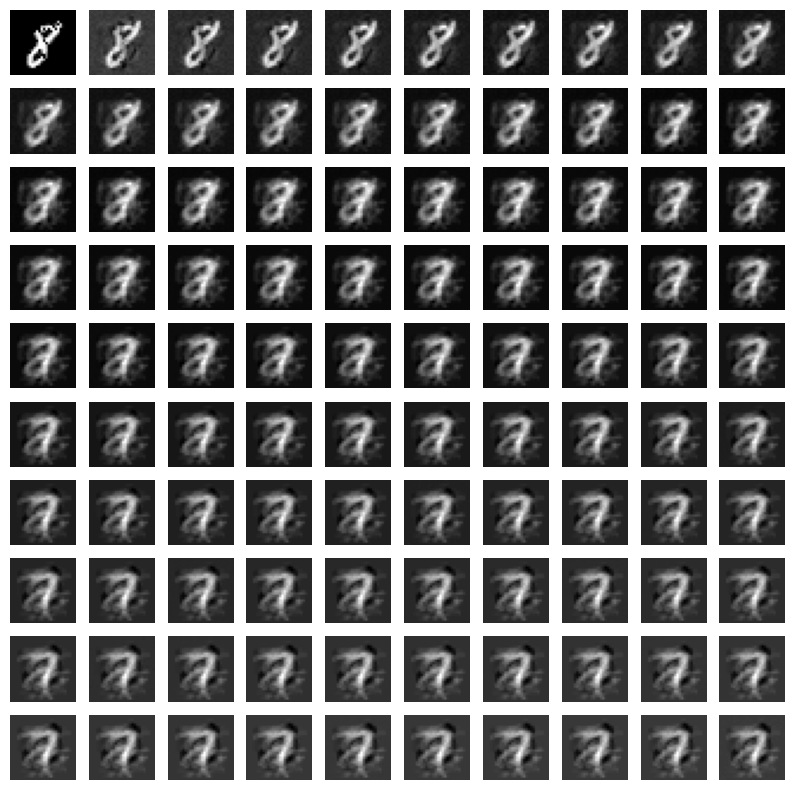

In [35]:
model.eval()
x = train_dataset.images[1].flatten(1).clone()
# x += torch.randn_like(x) * 0.3
x[torch.rand_like(x) > 0.8] = 0.0


# Plot the first 1st digit after multiple steps
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes):
    for j, ax2 in enumerate(ax):
        img = x.cpu().reshape(28,28).detach()
        ax2.imshow(img, cmap='gray')
        x, _ = model.reconstruct(x, steps=20)
        ax2.axis('off')

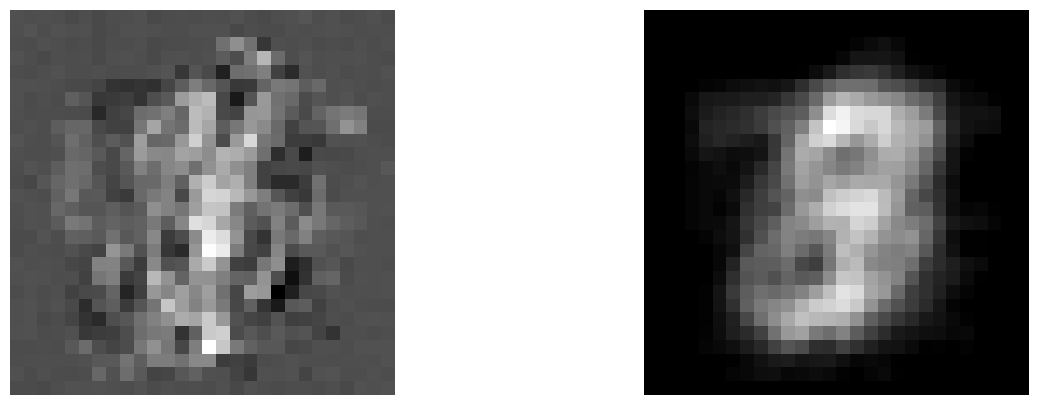

In [23]:
img = model.top.bias.data.cpu().numpy()
mean = train_dataset.transformed_images.mean(0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img.reshape(28, 28), cmap='gray')
axes[0].axis('off')
axes[1].imshow(mean.cpu().numpy().reshape(28, 28), cmap='gray')
axes[1].axis('off')

plt.show()
